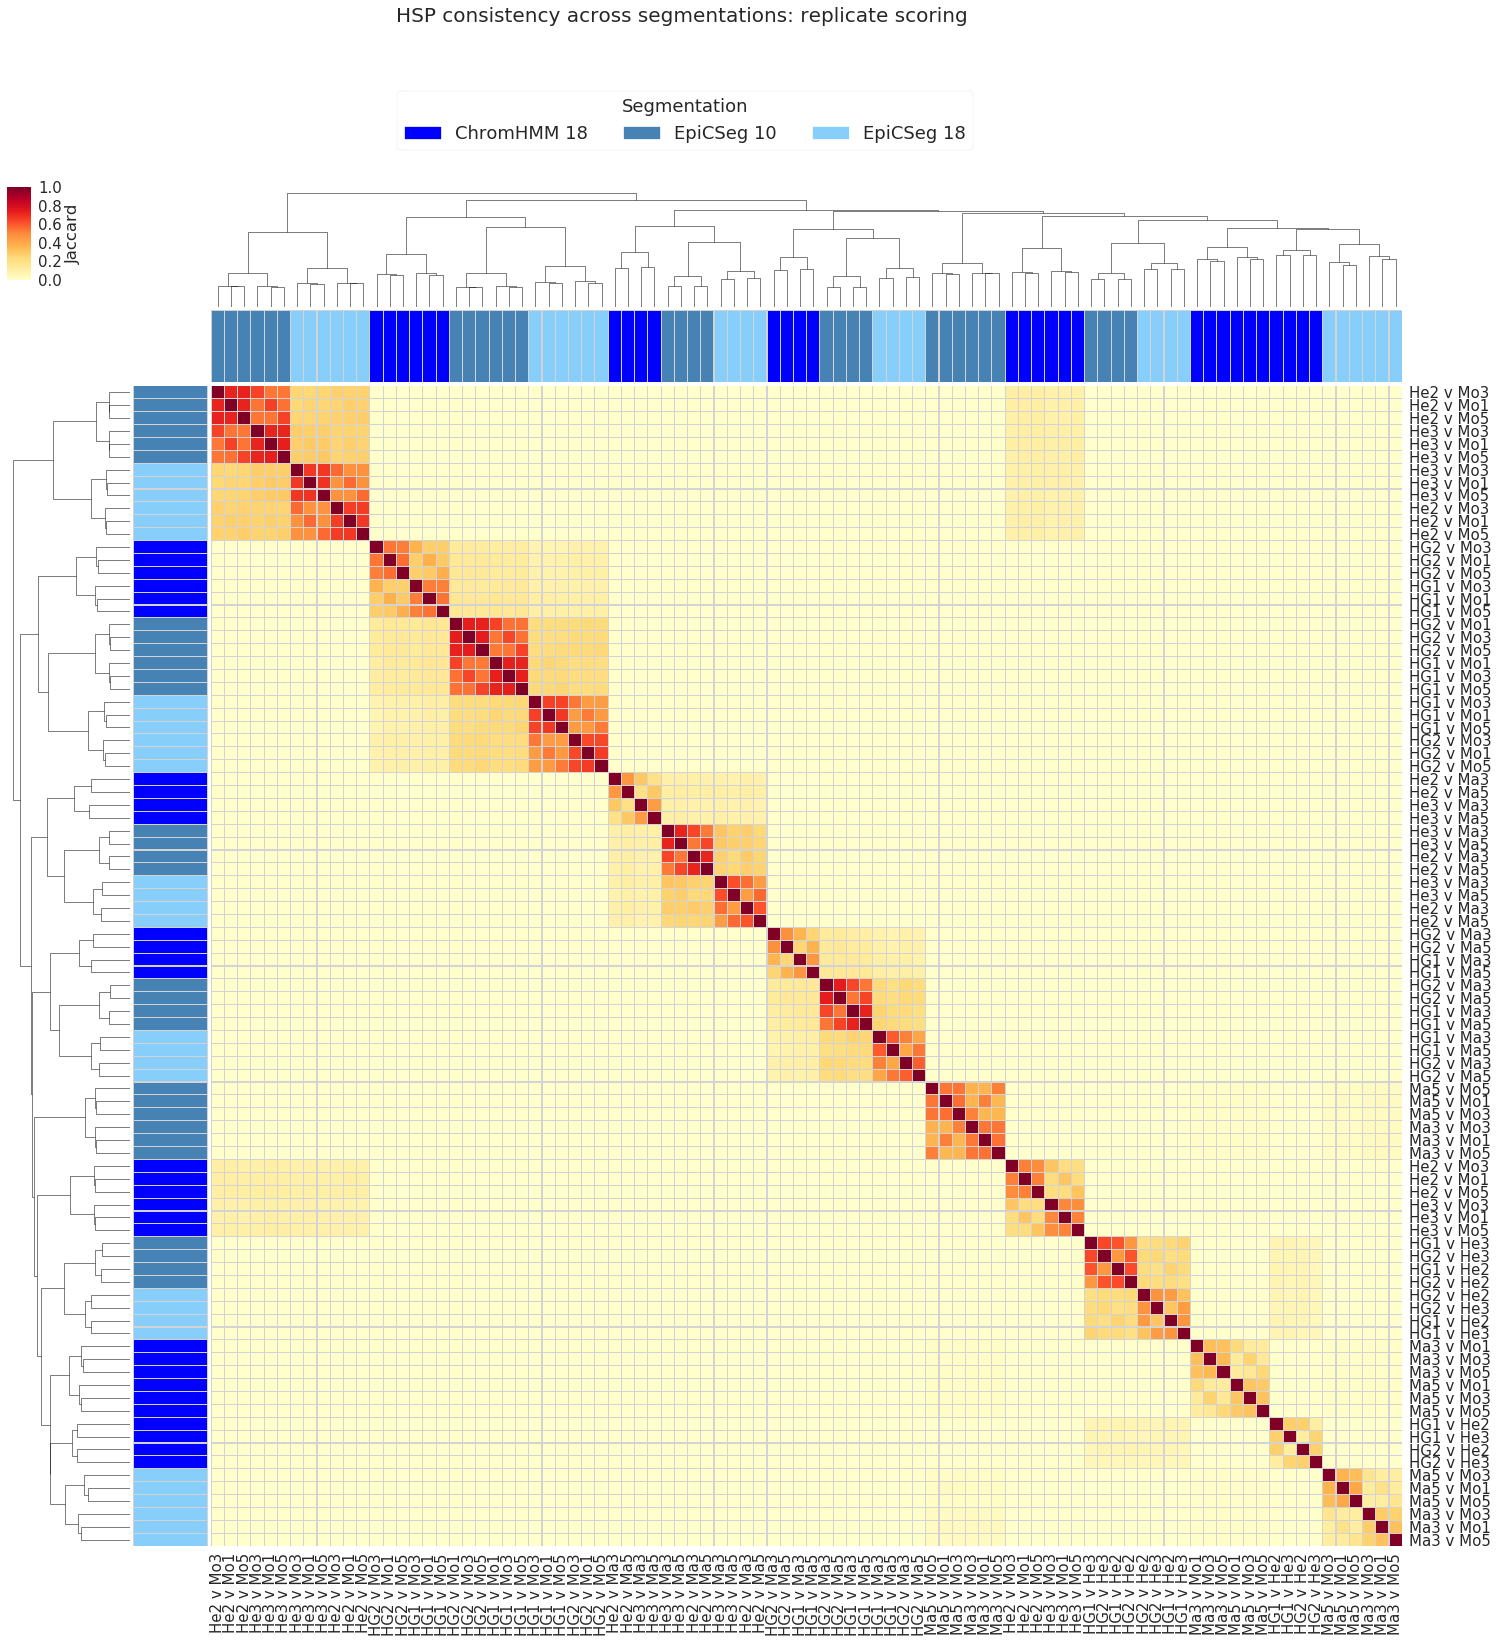

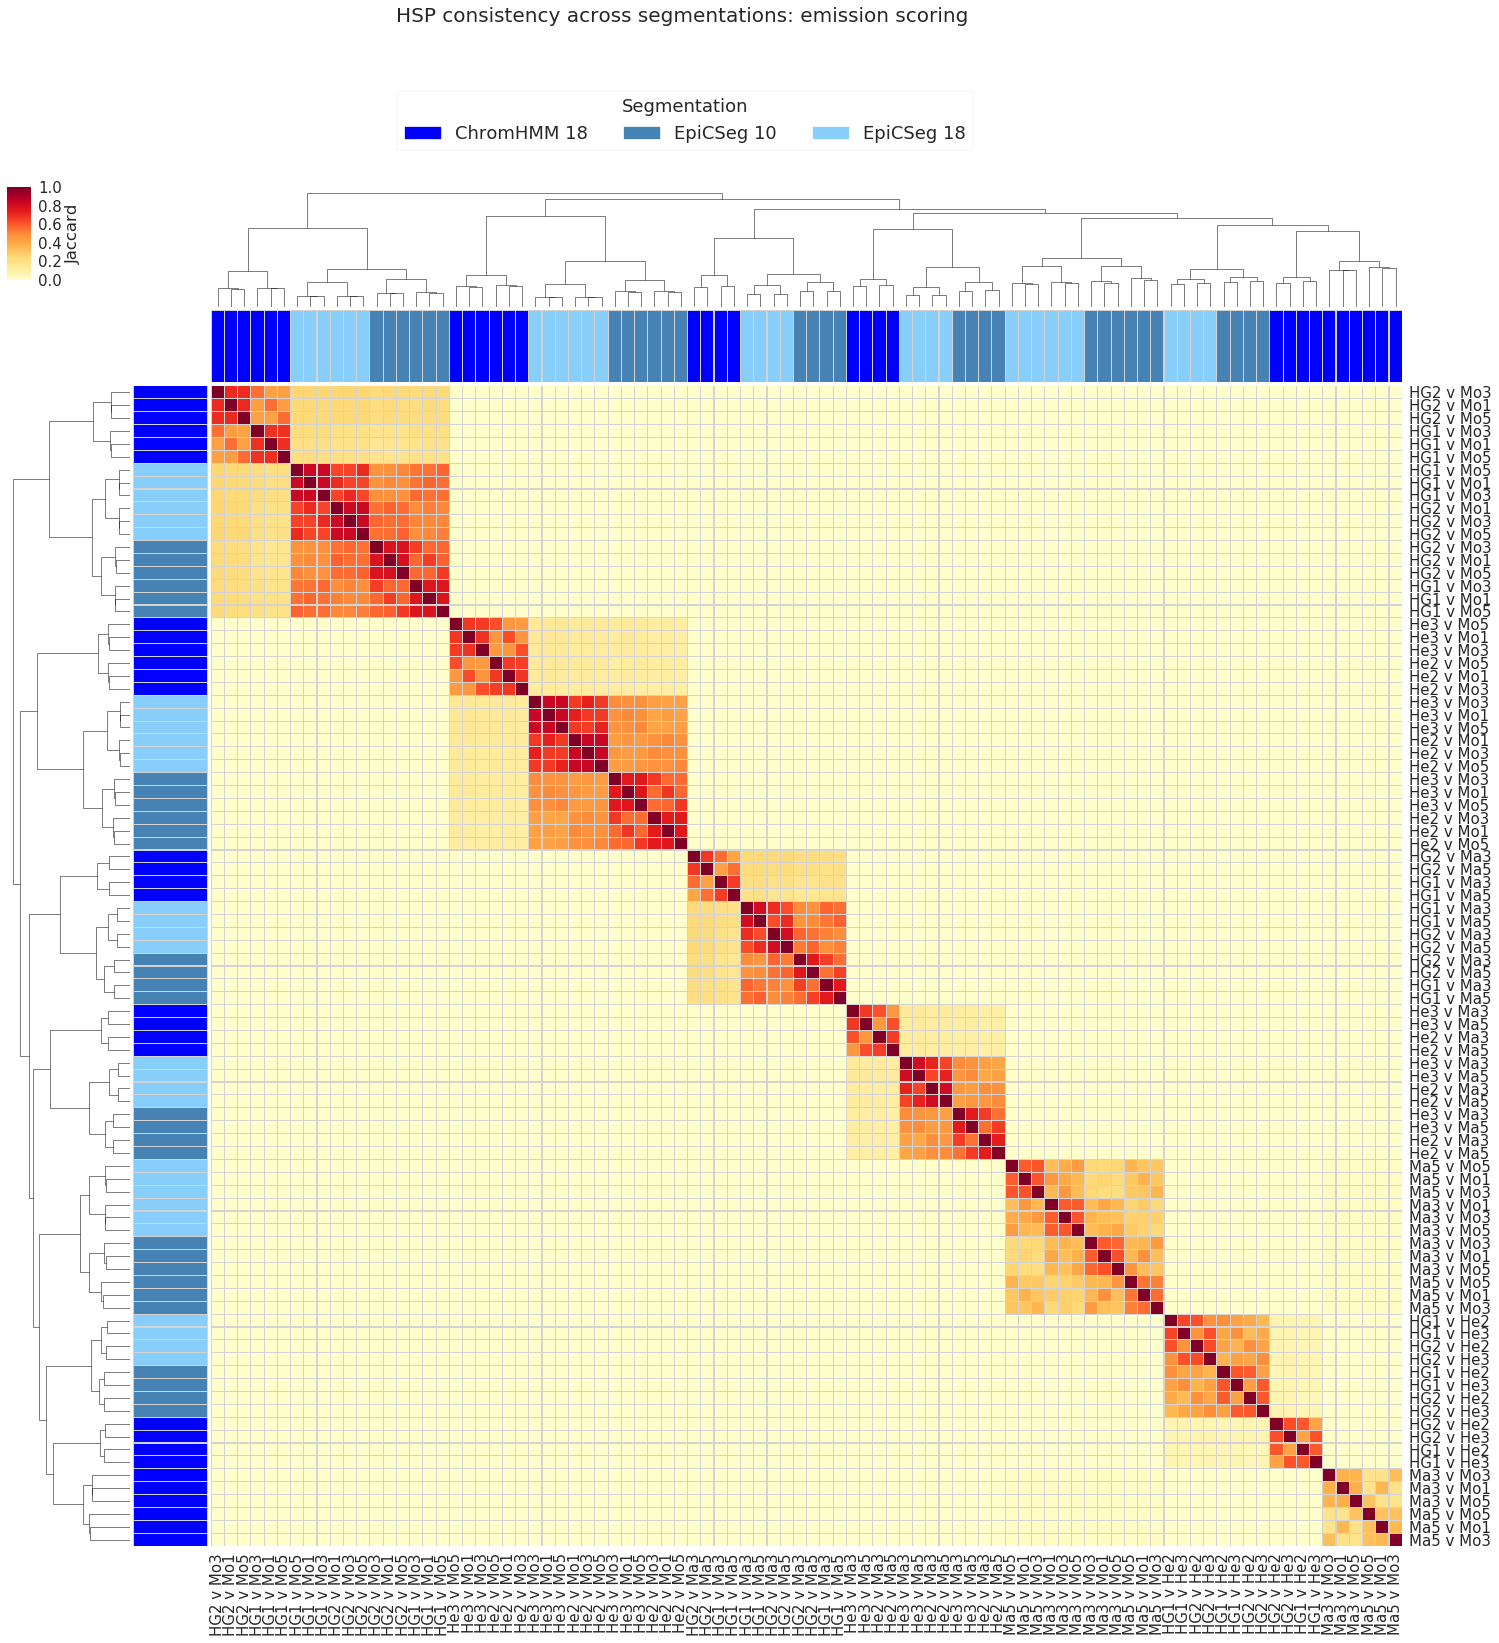

In [68]:
%matplotlib inline

import os as os
import collections as col
import itertools as itt
import pickle as pck
import time as ti

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import numpy.random as rng
import scipy.stats as stats
import pandas as pd
import seaborn as sns

# What does this do?
# Plot overlaps among region sets as heatmap
# with similarities calculated as Jaccard index

date = '20180320'

run_plot_repcons_heatmap = False
run_plot_scorecons_heatmap = False
run_plot_segcons_heatmap = True

save_figures = True

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

np.seterr(all='raise')

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis/projects/statediff'
cache_dir = os.path.join(fhgfs_base, 'caching/notebooks')

hsp_files_folder = os.path.join(fhgfs_base, 'solidstate/deep')

base_out = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/statediff'
fig_supp = os.path.join(base_out, 'figures', 'pub', 'supp')
fig_main = os.path.join(base_out, 'figures', 'pub', 'main')
fig_collect = os.path.join(base_out, 'figures', 'pub', 'collection')
                   
    
def collect_hsp_data(rootfolder):
    col_names = ['chrom', 'start', 'end', 'name', 'score',
                 'segpv', 'sumpv', 'sample1', 'sample2', 'rank', 'pct']
    collector = col.defaultdict(col.Counter)
    for root, dirs, datafiles in os.walk(rootfolder):
        if root.endswith('hsp_bed') and datafiles:
            for df in datafiles:
                data = pd.read_csv(os.path.join(root, df), sep='\t', header=None, skiprows=1,
                                   names=col_names, usecols=['start', 'end', 'sample1', 'sample2'])
                file_id = df.split('.')[0].split('_', 3)[-1]
                data['length'] = data['end'] - data['start']
                coverage = data.groupby(['sample1', 'sample2'])['length'].sum()
                collector[file_id].update(coverage.to_dict())
    return collector
    

def collect_region_overlaps(paths):
    col_names = ['chrom', 'start', 'end', 'name', 'score',
                 'segpv', 'sumpv', 'sample1', 'sample2', 'rank', 'pct']
    columns = [c + '_A' for c in col_names]
    columns.extend([c + '_B' for c in col_names])
    columns.append('overlap')
    collector = col.defaultdict(col.Counter)
    for path in paths:
        for root, dirs, tables in os.walk(path):
            if tables:
                for t in tables:
                    if t.endswith('.tsv'):
                        file_id1, file_id2 = t.split('.')[0].split('-isect-')
                        tpath = os.path.join(root, t)
                        ovl = pd.read_csv(tpath, sep='\t', header=None,
                                          names=columns, usecols=['sample1_A', 'sample2_A',
                                                                  'sample1_B', 'sample2_B',
                                                                  'overlap'])
                        ovl['overlap'] = ovl['overlap'].astype(np.int32)
                        shared = ovl.groupby(['sample1_A', 'sample2_A', 'sample1_B',
                                              'sample2_B'])['overlap'].sum()
                        shared = shared.astype(np.int32)
                        collector[file_id1, file_id2].update(shared.to_dict())
    return collector


def build_jaccard_dist_matrix(totals, shared, selectors, add_score=False, add_segment=False):
    jaccard = []
    labels = []
    for (file_a, file_b), overlaps in shared.items():
        if all([(s in file_a) and (s in file_b) for s in selectors]):
            for (a1, a2, b1, b2), ovl in overlaps.items():
                a_totals = totals[file_a][(a1, a2)]
                b_totals = totals[file_b][(b1, b2)] 
                j = np.round(ovl / (a_totals + b_totals - ovl), 3)                    
                a_label = a1[7] + a1[8] + a1[3] + ' v ' + a2[7] + a2[8] + a2[3]
                b_label = b1[7] + b1[8] + b1[3] + ' v ' + b2[7] + b2[8] + b2[3]
                if add_score:
                    a_label += ' ' + file_a.split('_')[-1][0].capitalize()
                    b_label += ' ' + file_b.split('_')[-1][0].capitalize()
                if add_segment:
                    seg_a = file_a.split('_')[0]
                    seg_a = seg_a[0].capitalize() + seg_a[-1]
                    a_label += ' ' + seg_a
                    seg_b = file_b.split('_')[0]
                    seg_b = seg_b[0].capitalize() + seg_b[-1]
                    b_label += ' ' + seg_b
                jaccard.append((a_label, b_label, j))
                jaccard.append((b_label, a_label, j))
                labels.extend([a_label, b_label])
    labels = sorted(set(labels))
    dim = len(labels)
    df = pd.DataFrame(np.zeros((dim, dim), dtype=np.float32),
                      index=labels, columns=labels)
    for r, c, j in jaccard:
        df.loc[r, c] = j
    return df    


def create_clustermap(data, title, figsize, col_annot=None, annot_label=None, legend_bb=None):
    """
    """
    exart = []
    if col_annot is not None:
        col_colors = []
        short_labels = []
        for c in data.columns:
            l, a = c.rsplit(' ', 1)
            col_colors.append(col_annot[a.strip()])
            short_labels.append(l.strip())
        data.columns = short_labels
        data.index = short_labels
    else:
        col_colors = None
    cm = sns.clustermap(data, method='average', metric='euclidean',
                        row_cluster=True, col_cluster=True, figsize=figsize,
                        vmin=0, vmax=1, center=0.5, cmap="YlOrRd", annot=False,
                        linewidths=0.1, linecolor='lightgrey', col_colors=col_colors,
                        row_colors=col_colors, cbar_kws={'label': 'Jaccard'},
                        xticklabels=data.columns, yticklabels=data.columns)
    if col_annot is not None:
        # Add tissue/color legend
        annot_handles = []
        for k, color in col_annot.items():
            label = annot_label[k]
            annot_handles.append(mpatches.Patch(color=color, label=label))
        
        leg_annot = plt.legend(handles=annot_handles, title=annot_label['title'],
                               markerscale=2, fontsize=16, loc=3, bbox_to_anchor=legend_bb,
                               prop={'size':18}, ncol=len(col_annot), frameon=True)
        exart.append(leg_annot)
    
    exart.append(cm.fig.suptitle(title, fontsize=20))
    return cm, exart
    
            
def plot_repcons_heatmap():
    isect_files = [os.path.join(fhgfs_base, 'bedtools/deep/hsp_isect/ident_ident_ident'),
                   os.path.join(fhgfs_base, 'bedtools/deep/hsp_isect/ident_diff_ident')]
    cache_file = os.path.join(cache_dir, '{}_plot_repcons_heatmap.pck'.format(date))
    if not os.path.isfile(cache_file):
        totals = collect_hsp_data(hsp_files_folder)
        shared = collect_region_overlaps(isect_files)
        with open(cache_file, 'wb') as cache:
            pck.dump({'totals': totals, 'shared': shared}, cache)
    else:
        with open(cache_file, 'rb') as cache:
            dump = pck.load(cache)
            totals = dump['totals']
            shared = dump['shared']
    fig_size = (20, 20)
    for seg in ['cmm18', 'ecs18', 'ecs10']:
        for mat in ['emission', 'replicate']:
            sim_mat = build_jaccard_dist_matrix(totals, shared, [seg, mat])
            title = 'HSP consistency across replicates: {} segmentation / {} scoring'.format(seg, mat)
            fig, exart = create_clustermap(sim_mat, title, fig_size)
            if save_figures:
                outname = '{}_fig_X_hsp_repcons_{}_{}'.format(date, seg, mat)
                out_svg = os.path.join(fig_collect, outname + '.svg')
                fig.savefig(out_svg, bbox_inches='tight', extra_artists=exart)
                out_pdf = os.path.join(fig_collect, outname + '.pdf')
                fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)
                out_png = os.path.join(fig_collect, outname + '.png')
                fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=300)
    return 0

def plot_scorecons_heatmap():
    isect_files = [os.path.join(fhgfs_base, 'bedtools/deep/hsp_isect/ident_ident_ident'),
                   os.path.join(fhgfs_base, 'bedtools/deep/hsp_isect/ident_ident_diff'),
                   os.path.join(fhgfs_base, 'bedtools/deep/hsp_isect/ident_diff_diff')]
    cache_file = os.path.join(cache_dir, '{}_plot_scorecons_heatmap.pck'.format(date))
    if not os.path.isfile(cache_file):
        totals = collect_hsp_data(hsp_files_folder)
        shared = collect_region_overlaps(isect_files)
        with open(cache_file, 'wb') as cache:
            pck.dump({'totals': totals, 'shared': shared}, cache)
    else:
        with open(cache_file, 'rb') as cache:
            dump = pck.load(cache)
            totals = dump['totals']
            shared = dump['shared']
    col_colors = {'R': 'blue', 'E': 'lightskyblue'}
    annot_labels = {'R': 'Replicate', 'E': 'Emission', 'title': 'Scoring matrix'}
    leg_bb = (20, 1.3)
    fig_size = (20, 20)
    for seg in ['cmm18', 'ecs18', 'ecs10']:
        sim_mat = build_jaccard_dist_matrix(totals, shared, [seg], True, False)
        title = 'HSP consistency across scoring matrices: {} segmentation'.format(seg)
        fig, exart = create_clustermap(sim_mat, title, fig_size, col_colors, annot_labels, leg_bb)
        if save_figures:
            outname = '{}_fig_X_hsp_scorecons_{}'.format(date, seg)
            out_svg = os.path.join(fig_collect, outname + '.svg')
            fig.savefig(out_svg, bbox_inches='tight', extra_artists=exart)
            out_pdf = os.path.join(fig_collect, outname + '.pdf')
            fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)
            out_png = os.path.join(fig_collect, outname + '.png')
            fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=300)
    return 0


def plot_segcons_heatmap():
    isect_files = [os.path.join(fhgfs_base, 'bedtools/deep/hsp_isect/ident_ident_ident'),
                   os.path.join(fhgfs_base, 'bedtools/deep/hsp_isect/other_ident_ident')]
    cache_file = os.path.join(cache_dir, '{}_plot_segcons_heatmap.pck'.format(date))
    if not os.path.isfile(cache_file):
        totals = collect_hsp_data(hsp_files_folder)
        shared = collect_region_overlaps(isect_files)
        with open(cache_file, 'wb') as cache:
            pck.dump({'totals': totals, 'shared': shared}, cache)
    else:
        with open(cache_file, 'rb') as cache:
            dump = pck.load(cache)
            totals = dump['totals']
            shared = dump['shared']
    col_colors = {'C8': 'blue', 'E8': 'lightskyblue', 'E0': 'steelblue'}
    annot_labels = {'C8': 'ChromHMM 18', 'E8': 'EpiCSeg 18',
                    'E0': 'EpiCSeg 10', 'title': 'Segmentation'}
    leg_bb = (16, 1.3)
    fig_size = (25, 25)
    for mat in ['replicate', 'emission']:
        sim_mat = build_jaccard_dist_matrix(totals, shared, [mat], False, True)
        title = 'HSP consistency across segmentations: {} scoring'.format(mat)
        fig, exart = create_clustermap(sim_mat, title, fig_size, col_colors, annot_labels, leg_bb)
        if save_figures:
            outname = '{}_fig_X_hsp_segcons_{}'.format(date, mat)
            out_svg = os.path.join(fig_collect, outname + '.svg')
            fig.savefig(out_svg, bbox_inches='tight', extra_artists=exart)
            out_pdf = os.path.join(fig_collect, outname + '.pdf')
            fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)
            out_png = os.path.join(fig_collect, outname + '.png')
            fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=300)
    return 0

        
    

if run_plot_repcons_heatmap:
    plot_repcons_heatmap()
    
if run_plot_scorecons_heatmap:
    plot_scorecons_heatmap()
    
if run_plot_segcons_heatmap:
    plot_segcons_heatmap()